# R-branch and P-branch of CO

In this tutorial, we learn R and P branches of carbon monooxide. Let's start from ploting the cross section of CO in 1900-2300 cm-1.

In [1]:
from exojax.database.api  import MdbExomol
from exojax.utils.grids import wavenumber_grid
nus,wave,resolution = wavenumber_grid(1900.0,2300.0,150000,xsmode="lpf")

2024-10-02 10:29:55.853116: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.20). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


xsmode =  lpf
xsmode assumes ESLOG in wavenumber space: xsmode=lpf
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order


Here, we use Exomol as the database of CO, excluding weak lines (see crit option). The number of the lines is only 565. 

In [2]:
mdb = MdbExomol("/home/kawahara/CO/12C-16O/Li2015",nurange=nus, crit=1.e-25, gpu_transfer=True)
print(len(mdb.nu_lines))

/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(


HITRAN exact name= (12C)(16O)
radis engine =  vaex
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/Li2015/12C-16O__Li2015.def
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/Li2015/12C-16O__Li2015.pf
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/Li2015/12C-16O__Li2015.states.bz2
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/12C-16O__H2.broad
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/12C-16O__He.broad
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/12C-16O__air.broad
Note: Caching states data to the vaex format. After the second time, it will become much faster.
Molecule:  CO
Isotopologue:  12C-16O
Background atmosphere:  H2
ExoMol database:  None
Local folder:  /home/kawahara/CO/12C-16O/Li2015
Transition files: 
	 => File 12C-16O__Li2015.trans
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/Li2015/12C-16O__Li2015.trans.bz2
		 => Caching the *.trans.bz2 file to the vaex (*.h5) format. After the second

Because the number of the lines is small, we use LPF as the opacity calculator. We assume T=1300K and P=1bar.

In [5]:
from exojax.database.hitran  import line_strength, doppler_sigma
from exojax.opacity.initspec import init_lpf
from exojax.database.exomol  import gamma_exomol, gamma_natural
from exojax.database import molinfo 
from exojax.opacity.lpf import xsvector
from exojax.utils.constants import Tref_original

Mmol = molinfo.molmass("CO")  # molecular weight
Tfix = 1300.0
Pfix = 1.0

numatrix = init_lpf(mdb.nu_lines, nus)  # initialization of LPF
qt = mdb.qr_interp(Tfix, Tref_original)  # partition function ratio
Sij = line_strength(
    Tfix, mdb.logsij0, mdb.nu_lines, mdb.elower, qt, Tref_original
)  # line strength
sigmaD = doppler_sigma(mdb.nu_lines, Tfix, Mmol)  # Doppler width
gammaL = gamma_exomol(Pfix, Tfix, mdb.n_Texp, mdb.alpha_ref) + gamma_natural(
    mdb.A
)  # Lorentz width

xsv = xsvector(numatrix, sigmaD, gammaL, Sij)  # compute cross section!

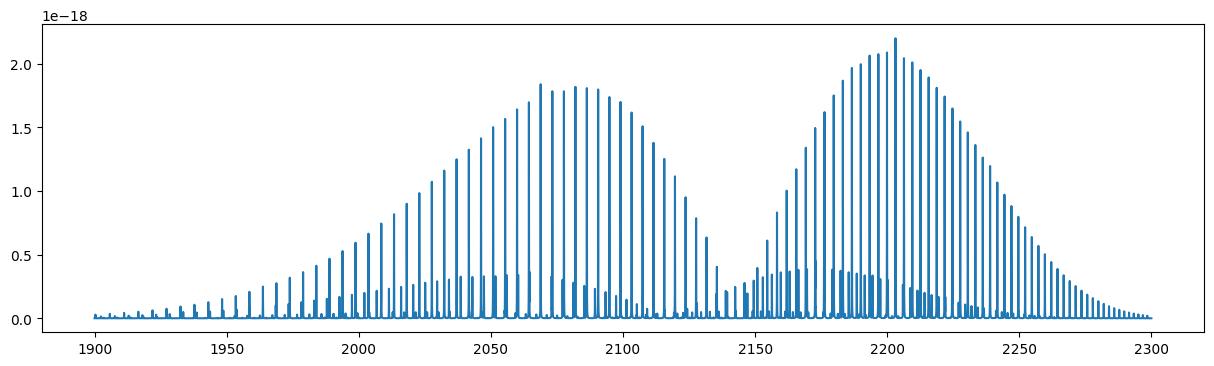

In [6]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(15,4))
plt.plot(nus,xsv)

This is a typical pattern of absorption for a diatomic molecule. These lines are gerenated by the so-called rotational-vibration transitions:

$\nu_{n,J} = \nu_n + \nu_J$

where $\nu_n$ is the vibration energy level and $\nu_J$ is the rotational energy level.
Recall the energy levels by a rigid rotation you learned at quantum physics is written as

$\nu_J = B J (J+1)$ 

where $B = \frac{h}{8 \pi^2 \mu r^2 c} J(J+1)$, just in case. 
The selection rule allows $\Delta J = J_{upper} - J_{lower} = \pm 1$. 
$\Delta J = 1$ is called the R-branch, while $\Delta J = -1$ is the P-branch. 
Then, the line center of the R-branch as a function of the upper $J$ ($J_{upper}$) is 

$\hat{\nu}^R_{J_{upper}} = \nu_n + (\nu_{J_{upper}} - \nu_{J_{upper}-1}) = \nu_n + 2 B J_{upper}$ (1)

So, ideally, we will see a constant increase of the line center as $J_{upper}$ value. Similaly, 
On the other hand, we will see a constant decrease for the P-branch as $J_{upper}$.

$\hat{\nu}^P_{J_{upper}} = \nu_n + (\nu_{J_{upper}-1} - \nu_{J_{upper}}) = \nu_n - 2 B J_{upper}$ (2)


Let's check $\Delta J$ in mdb:


In [7]:
import matplotlib.pyplot as plt
jj = mdb.jupper - mdb.jlower

import numpy as np
print(np.unique(jj))

[-1  1]


Yes, we have the lines only with $\Delta J = \pm 1$. Let's plot them separately, using the masking. 

In [8]:
mask_R = jj == 1.0
numatrix = init_lpf(mdb.nu_lines[mask_R],nus)
xsv_R=xsvector(numatrix,sigmaD[mask_R],gammaL[mask_R],Sij[mask_R])

mask_P = jj == -1.0
numatrix = init_lpf(mdb.nu_lines[mask_P],nus)
xsv_P=xsvector(numatrix,sigmaD[mask_P],gammaL[mask_P],Sij[mask_P])

We can see that the left and right peaks correspond to the R- and P- branches, respectively! The line centers as a function of $J_{upper}$ in the lower panel is what we expected in Equations (1) and (2)! 

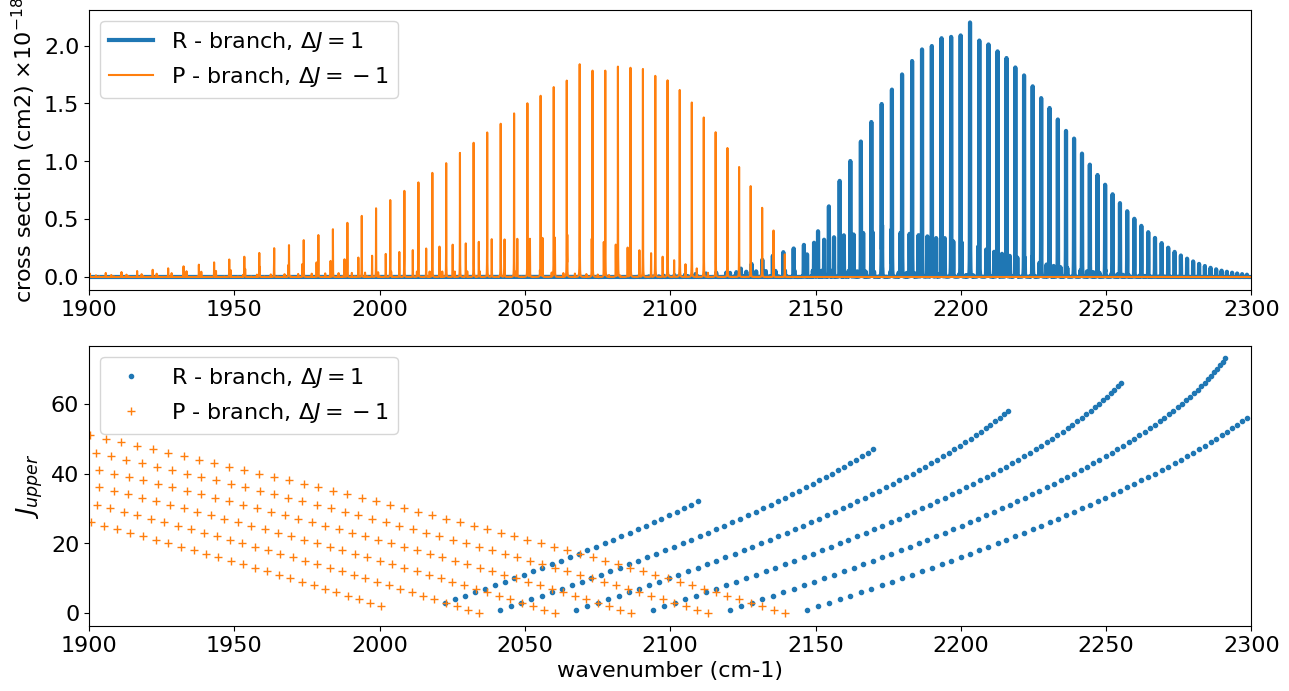

In [9]:
#c=["black","gray"]
c=["C0","C1"]
scale=10**-18
fig=plt.figure(figsize=(15,8))
ax = fig.add_subplot(211)
plt.plot(nus,xsv_R/scale,color=c[0],lw=3, label="R - branch, $\Delta J = 1$")
plt.plot(nus,xsv_P/scale,color=c[1], label="P - branch, $\Delta J = -1$")
plt.ylabel("cross section (cm2) $\\times 10^{-18}$",fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.xlim(nus[0],nus[-1])

ax = fig.add_subplot(212)
plt.plot(mdb.nu_lines[mask_R],mdb.jupper[mask_R],".",color=c[0], label="R - branch, $\Delta J = 1$")
plt.plot(mdb.nu_lines[mask_P],mdb.jupper[mask_P],"+",color=c[1], label="P - branch, $\Delta J = -1$")
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.xlim(nus[0],nus[-1])
plt.xlabel("wavenumber (cm-1)",fontsize=16)
plt.ylabel("$J_{upper}$",fontsize=18)

#plt.savefig("rpbranch.png", bbox_inches="tight", pad_inches=0.0)
plt.show()

## CO band head in K-band

We are (?) exoplanet astronomers! Check the famous CO bandhead at 2.3 micron!

In [10]:
nus,wave,resolution = wavenumber_grid(22900.0,23900.0,100000,unit="AA",xsmode="lpf")
mdb = MdbExomol("/home/kawahara/CO/12C-16O/Li2015",nurange=nus, crit=1.e-30,gpu_transfer=True)
print(len(mdb.nu_lines))

xsmode =  lpf
xsmode assumes ESLOG in wavenumber space: xsmode=lpf
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
HITRAN exact name= (12C)(16O)
radis engine =  vaex
Molecule:  CO
Isotopologue:  12C-16O
Background atmosphere:  H2
ExoMol database:  None
Local folder:  /home/kawahara/CO/12C-16O/Li2015
Transition files: 
	 => File 12C-16O__Li2015.trans
Broadening code level: a0


/home/kawahara/exojax/src/exojax/utils.grids.py:63: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(


323


/home/kawahara/exojax/src/radis/radis/api/exomolapi.py:685: AccuracyWarning: The default broadening parameter (alpha = 0.07 cm^-1 and n = 0.5) are used for J'' > 80 up to J'' = 95
  warnings.warn(


In [13]:
numatrix = init_lpf(mdb.nu_lines, nus)  # initialization of LPF
qt = mdb.qr_interp(Tfix, Tref_original)  # partition function ratio
Sij = line_strength(
    Tfix, mdb.logsij0, mdb.nu_lines, mdb.elower, qt, Tref_original
)  # line strength
sigmaD = doppler_sigma(mdb.nu_lines, Tfix, Mmol)  # Doppler width
gammaL = gamma_exomol(Pfix, Tfix, mdb.n_Texp, mdb.alpha_ref) + gamma_natural(
    mdb.A
)  # Lorentz width

In [14]:
jj = mdb.jupper - mdb.jlower
print(np.unique(jj))

[-1  1]


In [15]:
mask_R = jj == 1.0
numatrix = init_lpf(mdb.nu_lines[mask_R],nus)
xsv_R=xsvector(numatrix,sigmaD[mask_R],gammaL[mask_R],Sij[mask_R])

mask_P = jj == -1.0
numatrix = init_lpf(mdb.nu_lines[mask_P],nus)
xsv_P=xsvector(numatrix,sigmaD[mask_P],gammaL[mask_P],Sij[mask_P])


We can visualize how the bandhead would appear! So... the rigid rotation approximation is no longer valid for higher $J_{upper}$, which creates the bandhead. This is because a faster rotation increases the molecular distance, $r$, due to the centrifugal force then decreases the rotational constant $B = \frac{h}{8 \pi^2 \mu r^2 c} J(J+1)$. It makes the dependence of $J_{upper}$ on Equation (1) weaker than linear, and at some point, reverses it. This critical point corresonds to the band head in the R branch.

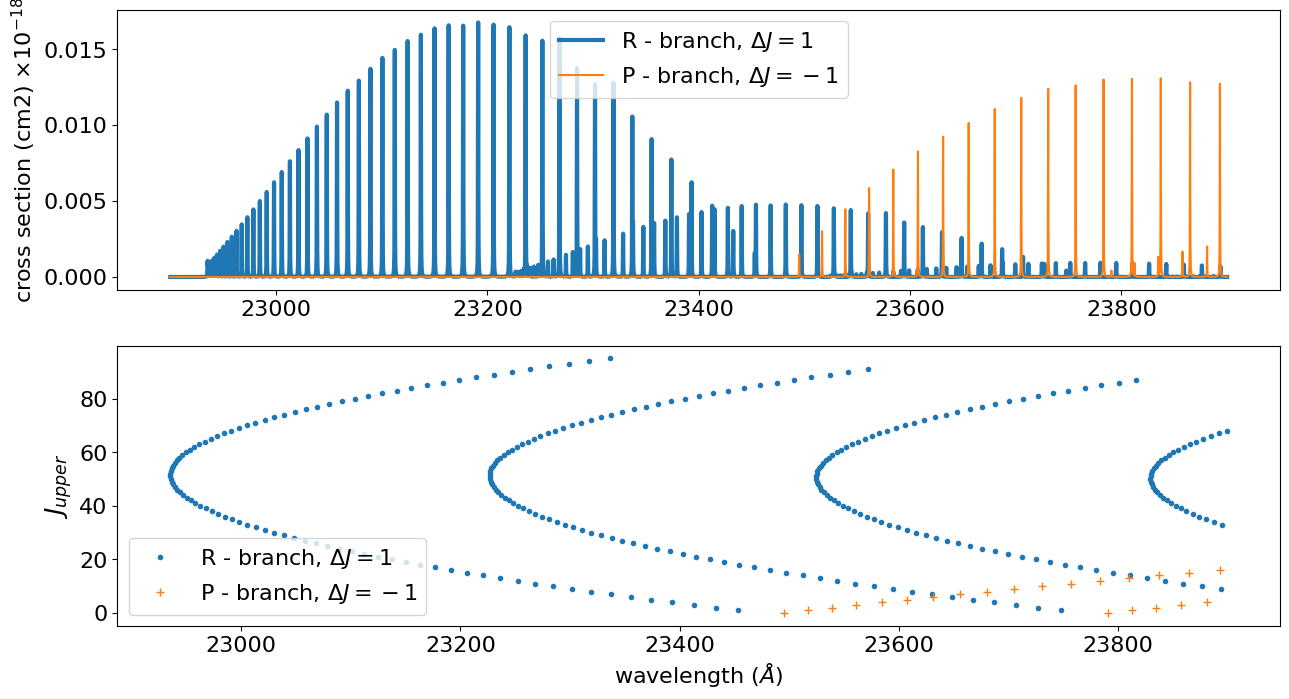

In [19]:
#c=["black","gray"]
c=["C0","C1"]
scale=10**-18
fig=plt.figure(figsize=(15,8))
ax = fig.add_subplot(211)
plt.plot(wave,xsv_R/scale,color=c[0],lw=3, label="R - branch, $\Delta J = 1$")
plt.plot(wave,xsv_P/scale,color=c[1], label="P - branch, $\Delta J = -1$")
plt.ylabel("cross section (cm2) $\\times 10^{-18}$",fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
#plt.xlim(wave[0],wave[-1])
ax = fig.add_subplot(212)
plt.plot(1.e8/mdb.nu_lines[mask_R],mdb.jupper[mask_R],".",color=c[0], label="R - branch, $\Delta J = 1$")
plt.plot(1.e8/mdb.nu_lines[mask_P],mdb.jupper[mask_P],"+",color=c[1], label="P - branch, $\Delta J = -1$")
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
#plt.xlim(wave[0],wave[-1])
plt.xlabel("wavelength ($\\AA$)",fontsize=16)
plt.ylabel("$J_{upper}$",fontsize=18)
#plt.savefig("bandhead.png", bbox_inches="tight", pad_inches=0.0)
plt.show()